# Method comparisons for inference

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import memento.simulate as simulate

In [4]:
import matplotlib
matplotlib.rcParams['legend.handlelength'] = 0

In [5]:
data_path = '/data_volume/memento/simulation/inference/'

### Compare DE methods

In [131]:
de_norm_adata = sc.read(data_path + 'de_filtered_norm.h5ad')

In [132]:
result = pd.read_csv(data_path + 'memento_de.csv')
A_data, B_data = de_norm_adata[de_norm_adata.obs['ct_real'] == 'A'].X, de_norm_adata[de_norm_adata.obs['ct_real'] == 'B'].X
_, result['ttest'] = stats.ttest_ind(A_data, B_data, equal_var=False)
result['mwu'] = np.array([stats.ranksums(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [133]:
result['null'] = de_norm_adata.var['is_null'].values
result['sig'] = ~result['null']
result['memento'] = result['de_pval']

In [134]:
result['ttest_fdr'] = memento.util._fdrcorrect(result['ttest'])
result['memento_fdr'] = memento.util._fdrcorrect(result['de_pval'])
result['mwu_fdr'] = memento.util._fdrcorrect(result['mwu'])

In [135]:
thresholds = np.linspace(0.05, 0.5, 10)
tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in ['memento', 'ttest', 'mwu']:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds:
    
        tpr.append((result.query('sig')[method] < thresh).mean())
        fdr.append(result.query('{} < {}'.format(method, thresh))['null'].mean())
        fpr.append((result.query('null')[method] < thresh).mean())
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

In [136]:
plt.cycler("color", ['lightseagreen', 'blue'])

'lightseagreen'
'blue'


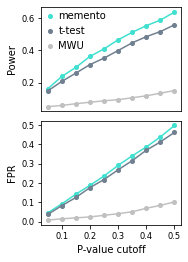

In [138]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in ['memento', 'ttest', 'mwu']:
    plt.plot(thresholds, tpr_dict[method], '-o', label=method, ms=4)
plt.legend(['memento', 't-test', 'MWU'], frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('Power'); plt.xticks([])

plt.subplot(2, 1, 2)
for method in ['memento', 'ttest', 'mwu']:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
plt.ylabel('FPR')
plt.xlabel('P-value cutoff')

plt.savefig('de_comparison.pdf', bbox_inches='tight')

In [74]:
# plt.figure(figsize=(2.5, 2))
# for col in ['de_pval', 'ttest', 'mwu']:
    
#     fpr, tpr, t = roc_curve(result['sig'], 1-result[col])
#     plt.plot(fpr, tpr, label=col)
    
# plt.legend(['memento', 't-test', 'MWU'])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('AUC curve (Differential mean)')
# plt.xlim(-0.01, 0.4);
# plt.ylim(-0.01, 0.6)
# plt.plot([0, 0.4], [0, 0.4], '--', color='black')

### Compare DV methods

In [88]:
dv_norm_adata = sc.read(data_path + 'dv_filtered_norm.h5ad')
result = pd.read_csv(data_path + 'memento_dv.csv')
result['null'] = dv_norm_adata.var['is_null'].values
result['sig'] = dv_norm_adata.var['is_sig'].values
basics_dv = pd.read_csv(data_path +'dv_basics.csv')
result = result.merge(basics_dv, left_on='gene', right_on='GeneName')

In [89]:
result['memento'] = result['dv_pval']
result['basics'] = result['ProbDiffResDisp']

In [90]:
thresholds = np.linspace(0.05, 0.5, 10)
tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in ['memento', 'basics']:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds:
    
        tpr.append((result.query('sig')[method] < thresh).mean())
        fdr.append(result.query('{} < {}'.format(method, thresh))['null'].mean())
        fpr.append((result.query('null')[method] < thresh).mean())
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

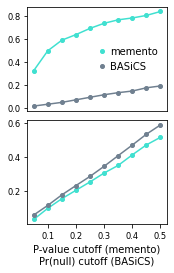

In [92]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in ['memento', 'basics']:
    plt.plot(thresholds, tpr_dict[method], '-o', label=method, ms=4)
plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
plt.xticks([])

plt.subplot(2, 1, 2)
for method in ['memento', 'basics']:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.ylabel('FPR')
plt.xlabel('P-value cutoff (memento)\nPr(null) cutoff (BASiCS)')

plt.savefig('dv_comparison.pdf', bbox_inches='tight')

In [193]:
# plt.figure(figsize=(2.5, 2))
# for col in ['dv_pval', 'ProbDiffResDisp']:
    
#     if col == 'dv_pval':
#         fpr, tpr, t = roc_curve(result['sig'], 1-result[col])
#         plt.plot(fpr, tpr, label=col)
#     if col == 'ProbDiffResDisp':
#         fpr, tpr, t = roc_curve(result['sig'], result[col])
#         plt.plot(fpr, tpr, label=col)   
# plt.legend(['memento', 'BASiCS'])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('Differential variability')
# # plt.xlim(-0.01, 0.4);
# # plt.ylim(-0.01, 0.6)
# plt.plot([0, 1], [0, 1], '--', color='black')

### Compare DC methods

In [122]:
result = pd.read_csv(data_path + 'memento_dc.csv')
schot_df = pd.read_csv(data_path + 'dc_schot.csv')
result = result.merge(schot_df, on=['gene_1', 'gene_2'])
result['sig'] = (result['gene_1'] < 400) & (result['gene_2'] < 400)
result['null'] = ~result['sig']

result['schot'] = result['pvalEstimated']
result['memento'] = result['corr_pval']

result['schot_es'] = result['globalHigherOrderFunction']
result['memento_es'] = result['corr_coef']

with open(data_path + 'dc_true_effect_size.pkl', 'rb') as f:
    true_es_matrix = pkl.load(f)
indices = list(itertools.combinations(np.arange(true_es_matrix.shape[0]), 2))
pos_idxs = pd.DataFrame(indices, columns=['gene_1', 'gene_2'])
a,b = zip(*indices)
pos_idxs['true_es'] = true_es_matrix[(a,b)]

result = result.merge(pos_idxs, on=['gene_1', 'gene_2'], how='left')
result['true_es'] = result['true_es'].fillna(value=0)
result['memento_sign'] = (result['memento_es']*result['true_es']) > 0
result['schot_sign'] = (result['schot_es']*result['true_es']) > 0

In [123]:
thresholds = np.linspace(0.05, 0.5, 10)
tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in ['memento', 'schot']:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds:
    
        tpr.append( ( (result.query('sig')[method] < thresh) & result.query('sig')[method+'_sign']   ).mean())
        fdr.append(    (result.query('{} < {}'.format(method, thresh))['null']   |   ~result.query('{} < {}'.format(method, thresh))[method+'_sign']    ).mean())
        fpr.append((result.query('null')[method] < thresh).mean())
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

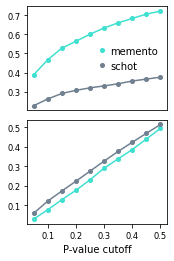

In [126]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in ['memento', 'schot']:
    plt.plot(thresholds, tpr_dict[method], '-o', label=method, ms=4)
plt.legend(['memento', 'schot'], frameon=False, loc='center right')
plt.xticks([])

plt.subplot(2, 1, 2)
for method in ['memento', 'schot']:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.ylabel('FPR')
# plt.plot([0, 0.5], [0, 0.5], '--', color='red')
plt.xlabel('P-value cutoff')

plt.savefig('dc_comparison.pdf', bbox_inches='tight')

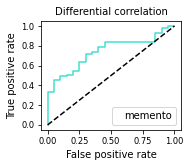

In [119]:
plt.figure(figsize=(2.5, 2))
for col in ['memento']:
    
    fpr, tpr, t = roc_curve(result.dropna()['sig'], 1-result.dropna()[col])
    plt.plot(fpr, tpr, label=col)
    
plt.legend(['memento'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Differential correlation')
# plt.xlim(-0.01, 0.4);
# plt.ylim(-0.01, 0.6)
plt.plot([0, 1], [0, 1], '--', color='black')

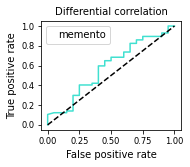

In [120]:
plt.figure(figsize=(2.5, 2))
for col in ['schot']:
    
    fpr, tpr, t = roc_curve(result.dropna()['sig'], 1-result.dropna()[col])
    plt.plot(fpr, tpr, label=col)
    
plt.legend(['memento'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Differential correlation')
# plt.xlim(-0.01, 0.4);
# plt.ylim(-0.01, 0.6)
plt.plot([0, 1], [0, 1], '--', color='black')